# Pole Arm Recognition with Keras

Much of the code in this notebook is "borrowed" from here: https://www.tensorflow.org/tutorials/keras/basic_classification

In this notebook we'll:

 1) Load and transform a bunch of training images
 
 2) Train a deep-learning model to classify those images
 
 3) Examine the outputs of the hidden layer of the model
 

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import os
import tensorflow as tf
from tensorflow import keras

## Load and process images

We're going to apply a bunch of transformations to our images - adding noise, flipping, stretching, transposing, and so on. This gives us a bigger and more diverse training set, as well as ensuring that the model learns meaningful features about the images, rather than incidentals.

In [1]:
def load_image(path, y_pixels=20, x_pixels=10):
    img = color.rgb2gray(plt.imread(path))
    y, x = img.shape
    idx = np.argmax([(img[i] != 1).any() for i in range(y)])
    img = img[idx:]
    y, x = img.shape
    y_adjust = y_pixels/y 
    img = np.hstack([img, [([1] * int(round(x_pixels - x * y_adjust, 0))) for _ in range(y)]])
    resized = resize(img, (y_pixels, x_pixels), anti_aliasing=True, mode='reflect')
    return resized

In [2]:
def transpose(img, threshold=0.75, x_pixels=10):
    safe_rows = [(img[:,i] <= threshold).any() for i in range(x_pixels)]
    images = []
    top_idx = np.argmax(safe_rows)
    for idx in range(top_idx):
        images.append(np.hstack([img[:,idx+1:], img[:,:idx+1]]))
    top_idx = np.argmax(safe_rows[::-1])
    for idx in range(top_idx):
        images.append(np.hstack([img[:,-(idx+1):], img[:,:-(idx+1)]]))
    return images

def flip(img):
    return np.fliplr(img)

In [3]:
def sp_noise(image, prob=0.05):
    output = np.zeros(image.shape)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 1
            else:
                output[i][j] = image[i][j]
    return output

In [4]:
def stretch(img, y_pixels=20, x_pixels=10):
    images = []
    for i in range(1, 3):
        images.append(resize(img[:,i:], (y_pixels, x_pixels), anti_aliasing=True, mode='reflect'))
        images.append(resize(img[:,:-i], (y_pixels, x_pixels), anti_aliasing=True, mode='reflect'))
        images.append(resize(img[i:,:], (y_pixels, x_pixels), anti_aliasing=True, mode='reflect'))
        images.append(resize(img[:-i,:], (y_pixels, x_pixels), anti_aliasing=True, mode='reflect'))
    return images


In [5]:
def make_synthetic_images(path, x=40, y=40):
    img = load_image(path, y_pixels=y, x_pixels=x)
    images = [img]
    images += stretch(img, y_pixels=y, x_pixels=x)
    images += transpose(img, x_pixels=x)
    images += [flip(im) for im in images]
    images += [sp_noise(im, prob=0.05) for im in images] 
    return images

In [9]:
label_names = [label_name for label_name in os.listdir('images/') if label_name[0] != '.' and label_name != 'bill']

In [35]:
## Warning! Slow!

train_images = []
train_labels = []
test_images = []
test_labels = []
n_test_images = 6

label = 0
for label_name in label_names:
    files = [file_path for file_path in os.listdir(f'images/{label_name}') if file_path[0] != '.']
    random.shuffle(files)
    for file in files[:n_test_images]:
        path = f'images/{label_name}/{file}'
        img = load_image(path, y_pixels=40, x_pixels=40)
        test_images.append(img)
        test_labels.append(label)
    for file in os.listdir(f'images/{label_name}')[n_test_images:]:
        path = f'images/{label_name}/{file}'
        new_images = make_synthetic_images(path)
        new_labels = [label] * len(new_images)
        train_images += new_images
        train_labels += new_labels
    label += 1

train_shuffle = np.random.permutation(len(train_images))
test_shuffle = np.random.permutation(len(test_images))
train_images = np.array(train_images)[train_shuffle]
train_labels = np.array(train_labels)[train_shuffle]
test_images = np.array(test_images)[test_shuffle]
test_labels = np.array(test_labels)[test_shuffle]

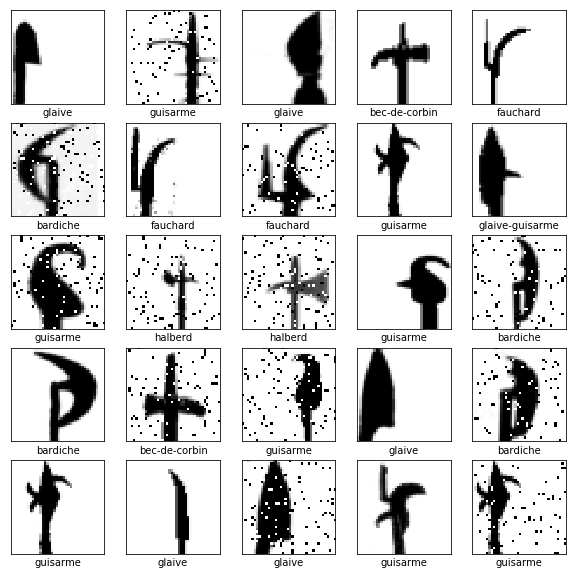

In [36]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(1 - train_images[i], cmap=plt.cm.binary)
    plt.xlabel(label_names[train_labels[i]])
plt.show()

## Train Model

We're using two hidden layers in our model because this gave slightly more accurate results, and also because the lower-dimensionality embeddings were more meaningful for the later analysis.

In [37]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(40, 40)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(30, activation=tf.nn.relu),
    keras.layers.Dense(len(label_names), activation=tf.nn.softmax)
])

In [38]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model.fit(train_images, train_labels, epochs=25)

Epoch 1/25
29920/29920 [==============================] - 6s 217us/sample - loss: 1.5916 - acc: 0.3566
Epoch 2/25
29920/29920 [==============================] - 5s 176us/sample - loss: 1.1247 - acc: 0.5474
Epoch 3/25
29920/29920 [==============================] - 3s 113us/sample - loss: 0.8802 - acc: 0.6512
Epoch 4/25
29920/29920 [==============================] - 4s 128us/sample - loss: 0.7459 - acc: 0.7084
Epoch 5/25
29920/29920 [==============================] - 6s 199us/sample - loss: 0.6497 - acc: 0.7442
Epoch 6/25
29920/29920 [==============================] - 6s 198us/sample - loss: 0.5709 - acc: 0.7749
Epoch 7/25
29920/29920 [==============================] - 6s 201us/sample - loss: 0.5173 - acc: 0.8005
Epoch 8/25
29920/29920 [==============================] - 5s 165us/sample - loss: 0.4755 - acc: 0.8154
Epoch 9/25
29920/29920 [==============================] - 3s 117us/sample - loss: 0.4354 - acc: 0.8318
Epoch 10/25
29920/29920 [==============================] - 3s 116us/sampl

In [40]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

42/42 [==============================] - 0s 2ms/sample - loss: 0.0790 - acc: 0.9762
Test accuracy: 0.97619045


In [41]:
predictions = model.predict(test_images)

In [42]:
predicted_labels = [np.argmax(prediction) for prediction in predictions]

In [43]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_labels, predicted_labels)

array([[6, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 0, 0, 0, 0],
       [0, 0, 6, 0, 0, 0, 0],
       [0, 0, 0, 6, 0, 0, 0],
       [0, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 0, 0, 6, 0],
       [0, 0, 0, 0, 1, 0, 5]])

In [44]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(1-img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(label_names[predicted_label],
                                100*np.max(predictions_array),
                                label_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(len(label_names)), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

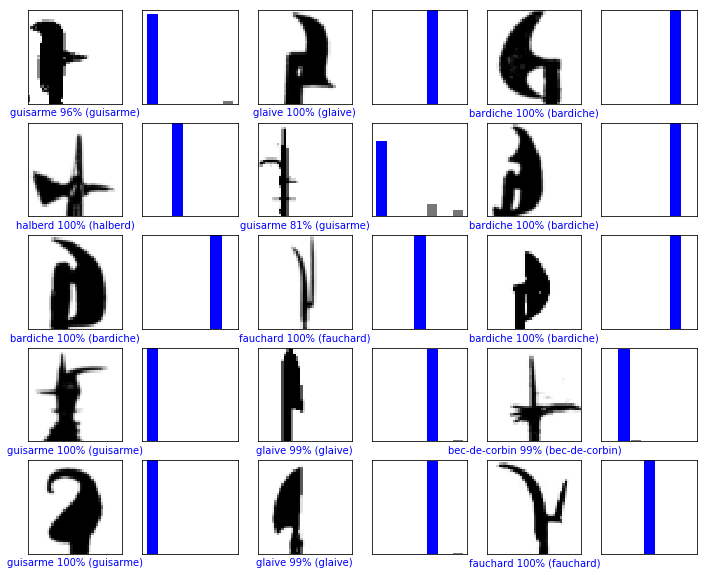

<Figure size 432x288 with 0 Axes>

In [45]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)
plt.show()
plt.savefig('predictions.png')

## Examine Embeddings

We're going to slice off the final layer of the classifier model, leaving just the bit that produces the length-30 embeddings. Then we can fool around with those embeddings to understand more about what the model has learned.

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3870      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 217       
Total params: 209,015
Trainable params: 209,015
Non-trainable params: 0
_________________________________________________________________


In [47]:
embedding_model = keras.Model(model.input, model.layers[2].output)

In [48]:
train_embeddings = embedding_model.predict(train_images)
test_embeddings = embedding_model.predict(test_images)

Taking the average guisarme, and the average glaive, and finding the image that is the closest match to the combination of those two.

In [50]:
#idx_target = train_embeddings[train_labels == idx].mean(axis=0).reshape(1, -1)
guisarme = train_embeddings[train_labels == 0].mean(axis=0).reshape(1, -1)
glaive = train_embeddings[train_labels == 4].mean(axis=0).reshape(1, -1)
target = (guisarme + glaive)/2

In [51]:
closest = np.argmin(euclidean_distances(target, test_embeddings))

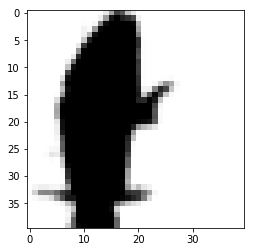

In [52]:
plt.imshow(1-test_images[closest], cmap=plt.cm.binary)

Finding the closest image to a randomly-selected image.

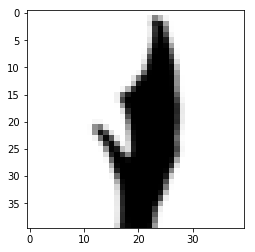

In [68]:
idx = random.choice(range(len(test_images)))
target = test_embeddings[idx].reshape(1, -1)
plt.imshow(1-test_images[idx], cmap=plt.cm.binary)

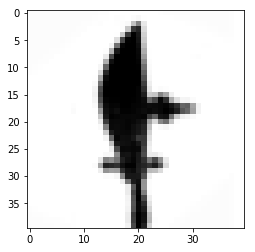

In [69]:
closest = np.argsort(euclidean_distances(target, test_embeddings))[0][1]
plt.imshow(1-test_images[closest], cmap=plt.cm.binary)

Finding the closest image from a set of flipped images.

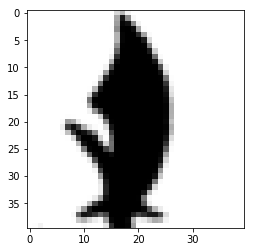

In [70]:
closest = np.argsort(euclidean_distances(target, test_embeddings))[0][2]
plt.imshow(1-test_images[closest], cmap=plt.cm.binary)

In [71]:
flipped_test_images = np.array([flip(img) for img in test_images])
flipped_test_embeddings = embedding_model.predict(flipped_test_images)

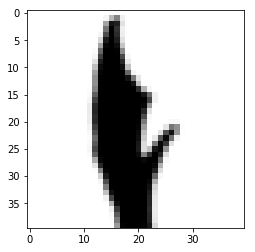

In [72]:
closest = np.argmin(euclidean_distances(target, flipped_test_embeddings))
plt.imshow(1-flipped_test_images[closest], cmap=plt.cm.binary)